# ltc_distribution_experimentation_analysis

> Look at the LTC distribution

This notebook will analyse the result of the LTC distribution simulations

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

jax.default_device(jax.devices('cpu')[0])
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_platform_name", "cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm
import CE_simulation.phase_analysis as ana
import CE_simulation.ltc_analysis as ltc_ana

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from tqdm.notebook import tqdm

from scipy import spatial, ndimage
from skimage.transform import downscale_local_mean

from collections import Counter
import itertools

from copy import deepcopy
import os
import pickle

In [ ]:
from joblib import Parallel, delayed
import gc

In [ ]:
from typing import Sequence, Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
## reloading the modules in case you edit them

import importlib

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso);
importlib.reload(drs); importlib.reload(dis); importlib.reload(ecm);

In [ ]:
def std_err(arr, axis=-1):
    return np.std(arr, axis=axis)/np.sqrt(arr.shape[axis])

In [ ]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2"

## Loading and evaluating the parameter scan simulations

Main purpose here is to demonstrate _robustness_ :  the simulations work even for different choices of various parameters. We will consider:

1. Dependence on:
    - tension balancing rate
    - passive relaxation rate
    - cutoff
2. Influence of initial condition:
    - gaussian noise in initial tension vertex positions 
    - orientation of hexagonal lattice
3. Area vs perimeter feedback 
4. Langevin noise in tension dynamiccs
5. Voronoi vs elastic energy minimization

We have only simulations with ordered initial conditions, we will not consider the interactions between parameters and disorder. We will average over 3 realizations and parallel vs orthogonal initial conditions.

We will show the following quantifications:

1. Extension & T1 rate vs time
2. Hexagon fraction & mean tension anisotropy vs time
3. LTC distribution at late times - show only a marginal? or medians as barplot inset?
4. For Langevin, area, and Voronoi, show final meshes

In [ ]:
## simulation sweep to load

orientations = ["parallel", "orthogonal"]
k_relaxs = [2, 1/4, 1/20] # 
k_passives = [4, 6, 12]
noise_gaussians = [0.05, 0.1, 0.15]
noise_dynamics = [0, 0.2]
feedbacks = ["perimeter", "area"]
use_voronois = [False, True]
k_cutoffs = [0.2, 0.3, 0.4] # 0.2 we alreay have from last simulation 

reps = np.array([1, 2, 3]) # number of replicates # 1, 2, 3

# k_relax and k passive dependence
to_do = list(itertools.product(orientations, k_relaxs, k_passives, [0.1,], ["perimeter",], [0,], [False,], [0.3,], reps))
# gaussian noise influence
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.05, 0.15], ["perimeter",], [0,], [False,], [0.3,], reps))
# area vs perimeter
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.1,], ["area",], [0,], [False,], [0.3,], reps))
# noise in tension dynamics
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.1,], ["perimeter",], [0.2, 0.3, 0.4, 0.5], [False,], [0.3,], reps))
# Voronoi simulations
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.1,], ["perimeter",], [0,], [True,], [0.3,], reps))
# cutoff dependence
to_do = to_do + list(itertools.product(orientations, [2], [6], [0.1,], ["perimeter",], [0,], [False,], [0.2, 0.4], reps))

n_steps = 500
step = 10

base_dir = "/data/Nikolas/GBE_simulation/runs/parameter_scans/parameter_scan_SI_once_more_again"

In [ ]:
len(to_do[0]), to_do[0]

(9, ('parallel', 2, 4, 0.1, 'perimeter', 0, False, 0.3, 1))

In [ ]:
elongation_dict = {}
valence_dict = {}
hex_dict = {}
anisos_dict_S = {}

T1_rate_dict = {}
LTC_dict = {}
meshes_dict = {}

In [ ]:
def load_data(orientation, k_relax, k, noise_gaussian, feedback, noise_dynamic, use_voronoi, k_cutoff, random_seed, return_meshes=False):
    sim_dir = f"{base_dir}/orientation_{orientation}_kRelax_{k_relax}_kPassive_{k}_noiseGaussian_{noise_gaussian}_feedback_{feedback}_noiseDynamic_{noise_dynamic}_voronoi_{use_voronoi}_cutoff_{k_cutoff}_randomSeed_{random_seed}"
    params = (orientation, k_relax, k, noise_gaussian, feedback, noise_dynamic, use_voronoi, k_cutoff, random_seed)
    try:
        meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                 for i in tqdm(range(0, n_steps, step))]

        valences = [ecm.get_valences(m) for m in meshes]
        anisos_S = np.stack([ana.get_anisos_S(m) for m in meshes])

        delta_series = [ana.get_width_height(m, q=0.8) for m in meshes]
        delta_series = ndimage.gaussian_filter1d(np.stack(delta_series)/delta_series[1], axis=0, sigma=1)
        delta_series = np.log(delta_series)
        elongation = np.exp((delta_series[:,0]-delta_series[:,1])/2)
        
        with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
            last_flipped_edges = pickle.load(f)
        T1_rate = [len(x) for x in last_flipped_edges[1:]]
        ltc_dist = [tns.angles_shape(np.array(list(m.get_vertex_angles(exclude=None, method="dual").values())).T)
                    for m in meshes]

        return_dict = {"params": params,
                       "valences": valences, "anisos_S": anisos_S,
                       "T1_rate": T1_rate, "elongation": elongation, "LTC": ltc_dist}
        if return_meshes:
            return_dict["meshes"] = meshes
        else:
            del meshes
            gc.collect()
    except ValueError:
        print(params)
        return_dict = {"params": params,
                       "valences": None, "anisos_S": None,
                       "T1_rate": None, "elongation": None, "LTC": None}
        if return_meshes:
            return_dict["meshes"] = None
    return return_dict


In [ ]:
len(to_do) /  3

38.0

In [ ]:
%%time

my_data = Parallel(n_jobs=38, prefer=None, timeout=99999)(delayed(load_data)(orientation, k_relax, k, noise_gaussian, feedback,
                                                                             noise_dynamic, use_voronoi, k_cutoff, random_seed,
                                                                             return_meshes=True) 
                        for orientation, k_relax, k, noise_gaussian, feedback, noise_dynamic, use_voronoi, k_cutoff, random_seed in to_do)

# should take 2 mins if all jobs run parallel

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and

CPU times: user 10min 12s, sys: 4min 8s, total: 14min 21s
Wall time: 15min 2s
  0%|          | 0/50 [00:00<?, ?it/s]


In [ ]:
dt = 0.005
dt_eff = step * dt * 25

sigma_T1 = 2

for item in my_data:
    if item["T1_rate"] is not None:
        n_cells = len(item["meshes"][0].vertices)
        key = item["params"]
        elongation_dict[key] = item["elongation"]
        valence_dict[key] = item["valences"]
        anisos_dict_S[key] = item["anisos_S"]
        LTC_dict[key] = item["LTC"]
        meshes_dict[key] = item["meshes"]
        T1_rate_dict[key] = downscale_local_mean(np.array(item["T1_rate"]), step) / (n_cells*dt)
        T1_rate_dict[key] = ndimage.gaussian_filter1d(T1_rate_dict[key][:int(n_steps/step )], sigma=sigma_T1)
hex_dict = {key: [x[6] for x in val] for key, val in valence_dict.items()}

In [ ]:
T1_rate_dict[key].shape

(50,)

In [ ]:
## set time

dt = 0.005
time = np.arange(elongation_dict[key].shape[0]) * step * dt * 25

In [ ]:
## compute averages over realizations, create pooled LTC distributions, across the three replicates

params = list(set([x[:-1] for x in to_do])) # unique parameter values

elongation_dict_mean = {key: np.mean([elongation_dict[key+(i,)] for i in reps], axis=0) for key in params}
T1_rate_dict_mean = {key: np.mean([T1_rate_dict[key+(i,)] for i in reps], axis=0) for key in params}
hex_dict_mean = {key: np.mean([hex_dict[key+(i,)] for i in reps], axis=0) for key in params}
anisos_dict_mean = {key: np.mean([anisos_dict_S[key+(i,)] for i in reps], axis=0) for key in params}
# special case - this is a distribution
ltc_dict_mean = {key: np.vstack([np.array(LTC_dict[key+(i,)]).T for i in reps]).T for key in params}

In [ ]:
# now also average over orientation

orientations = ["parallel", "orthogonal"]
params_ori = list(set([x[1:] for x in params]))

elongation_dict_mean_ori = {key: np.mean([elongation_dict_mean[(ori,)+key] for ori in orientations], axis=0) for key in params_ori}
T1_rate_dict_mean_ori = {key: np.mean([T1_rate_dict_mean[(ori,)+key] for ori in orientations], axis=0) for key in params_ori}
hex_dict_mean_ori = {key: np.mean([hex_dict_mean[(ori,)+key]  for ori in orientations], axis=0) for key in params_ori}
anisos_dict_mean_ori = {key: np.mean([anisos_dict_mean[(ori,)+key]  for ori in orientations], axis=0) for key in params_ori}
# special case - this is a distribution
ltc_dict_mean_ori = {key: np.vstack([np.array(ltc_dict_mean[(ori,)+key]).T for ori in orientations]).T for key in params_ori}

In [ ]:
drs.create_rect_initial

<function CE_simulation.drosophila.create_rect_initial(nx, ny, noise=0, initial_strain=0, isogonal=0, orientation='orthogonal', boundaries=None, w_passive=0, w_passive_lr=0, bdry_x=None, bdry_y=None, random_seed=0)>

In [ ]:
T1_rate_dict_mean_ori[params_ori[0]].shape

(50,)

In [ ]:
# also std devs - over both realizations and orientations? let's say just 

elongation_dict_std = {key: np.std([elongation_dict[key+(i,)] for i in reps], axis=0) for key in params}
T1_rate_dict_std = {key: np.std([T1_rate_dict[key+(i,)] for i in reps], axis=0) for key in params}
hex_dict_std = {key: np.std([hex_dict[key+(i,)] for i in reps], axis=0) for key in params}
anisos_dict_std = {key: np.std([anisos_dict_S[key+(i,)] for i in reps], axis=0) for key in params}

elongation_dict_std = {key: np.mean([elongation_dict_std[(ori,)+key] for ori in orientations], axis=0) for key in params_ori}
T1_rate_dict_std = {key: np.mean([T1_rate_dict_std[(ori,)+key] for ori in orientations], axis=0) for key in params_ori}
hex_dict_std = {key: np.mean([hex_dict_std[(ori,)+key] for ori in orientations], axis=0) for key in params_ori}
anisos_dict_std = {key: np.mean([anisos_dict_std[(ori,)+key] for ori in orientations], axis=0) for key in params_ori}

In [ ]:
# compute median shape angle and std error

mean_aniso_dict_mean_ori = {key: np.mean(val, axis=-1)[:,1] for key, val in ltc_dict_mean_ori.items()}
mean_phase_dict_mean_ori = {key: np.mean(val, axis=-1)[:,0]/np.pi for key, val in ltc_dict_mean_ori.items()}

# std error for these, distribution is too wide
std_aniso_dict_mean_ori = {key: std_err(val, axis=-1)[:,1] for key, val in ltc_dict_mean_ori.items()}
std_phase_dict_mean_ori = {key: std_err(val, axis=-1)[:,0]/np.pi for key, val in ltc_dict_mean_ori.items()}

In [ ]:
mean_aniso_dict_mean = {key: np.mean(val, axis=-1)[:,1] for key, val in ltc_dict_mean.items()}
mean_phase_dict_mean = {key: np.mean(val, axis=-1)[:,0]/np.pi for key, val in ltc_dict_mean.items()}


### Define plotting functions for Extension/T1 and Aniso/Hex frac

In [ ]:
def plot_ext_T1_aniso_hex_one_orientation(keys, labels):
    fig, (ax, bx, cx) = plt.subplots(figsize=(16, 4), ncols=3)

    
    alpha = 0.3
    ax2 = ax.twinx()
    for key, label, color in zip(keys, labels, colors):
    
        ax.plot(time, elongation_dict_mean[key], color=color, label=label) 
        ax.fill_between(time, elongation_dict_mean[key]-elongation_dict_std[key[1:]],
                         elongation_dict_mean[key]+elongation_dict_std[key[1:]], color=color, alpha=alpha)

        ax2.plot(time, T1_rate_dict_mean[key], color=color, ls=(0, (5, 5))) 
        ax2.fill_between(time, T1_rate_dict_mean[key]-T1_rate_dict_std[key[1:]],
                         T1_rate_dict_mean[key]+T1_rate_dict_std[key[1:]], color=color, alpha=alpha)

    ax.set_yticks([1, 1.5, 2])
    ax.set_yticklabels([1, 1.5, 2], fontsize=14);
    ax.set_ylim([0.95, 2])

    ax.set_xticks([0, 20, 40, 60])
    ax.set_xticklabels([0, 20, 40, 60], fontsize=14)
    ax.set_xlim([0, 55])

    ax.set_xlabel('Time [min]',fontsize=14)
    ax.set_ylabel(r'$\sqrt{a_t/a_0}$', fontsize=14)

    ax2.set_ylabel(r'T1 rate [1/(cell$\cdot$min)]', fontsize=14)
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels([0, 1, 2], fontsize=14);
    ax2.set_ylim([0, 3])

    bx2 = bx.twinx()
    for key, label, color in zip(keys, labels, colors):

        bx.plot(time, anisos_dict_mean[key][:,0], color=color, label=label) 
        bx.fill_between(time, anisos_dict_mean[key][:,0]-anisos_dict_std[key[1:]][:,0],
                         anisos_dict_mean[key][:,0]+anisos_dict_std[key[1:]][:,0], color=color, alpha=alpha)

        bx2.plot(time, hex_dict_mean[key], color=color, ls=(0, (5, 5))) 
        bx2.fill_between(time, hex_dict_mean[key]-hex_dict_std[key[1:]],
                         hex_dict_mean[key]+hex_dict_std[key[1:]], color=color, alpha=alpha)

    bx.set_yticks([0, 0.2, 0.4])
    bx.set_yticklabels([0, 0.2, 0.4], fontsize=14);
    bx.set_ylim([0, 0.4])

    bx.set_xticks([0, 20, 40, 60])
    bx.set_xticklabels([0, 20, 40, 60], fontsize=14)
    bx.set_xlim([0, 55])

    bx.legend(fontsize=12, loc="upper right")
    bx.set_xlabel('Time [min]',fontsize=14)
    bx.set_ylabel(r'Tension anisotropy $\langle|2\tilde{Q}|_2\rangle$', fontsize=14)

    bx2.set_ylabel(r'Hexagon fraction $p_6$', fontsize=14)
    bx2.set_yticks([0.4, 0.6, 0.8, 1])
    bx2.set_yticklabels([0.4, 0.6, 0.8, 1], fontsize=14);
    bx2.set_ylim([0.4, 1])
    
    cx2 = cx.twinx()
    for key, label, color in zip(keys, labels, colors):

        cx.plot(time, mean_aniso_dict_mean[key], color=color, label=label) 
        cx.fill_between(time, mean_aniso_dict_mean[key]-std_aniso_dict_mean_ori[key[1:]],
                         mean_aniso_dict_mean[key]+std_aniso_dict_mean_ori[key[1:]], color=color, alpha=alpha)

        cx2.plot(time, mean_phase_dict_mean[key], color=color, ls=(0, (5, 5))) 
        cx2.fill_between(time, mean_phase_dict_mean[key]-std_phase_dict_mean_ori[key[1:]],
                         mean_phase_dict_mean[key]+std_phase_dict_mean_ori[key[1:]], color=color, alpha=alpha)

    cx.set_yticks([0.2, 0.4])
    cx.set_yticklabels([0.2, 0.4], fontsize=14);
    cx.set_ylim([0.2, 0.5])

    cx.set_xticks([0, 20, 40, 60])
    cx.set_xticklabels([0, 20, 40, 60], fontsize=14)
    cx.set_xlim([0, 55])

    cx.set_xlabel('Time [min]',fontsize=14)
    cx.set_ylabel(r'LTC magnitude $\tilde{s}^2$', fontsize=14)

    cx2.set_ylabel(r'LTC phase $\tilde{\psi}/\pi$', fontsize=14)
    cx2.set_yticks([0.475, 0.5,])
    cx2.set_yticklabels([0.475, 0.5,], fontsize=14);
    cx2.set_ylim([0.46, 0.53])

    plt.subplots_adjust(wspace=0.5)
    
    return fig

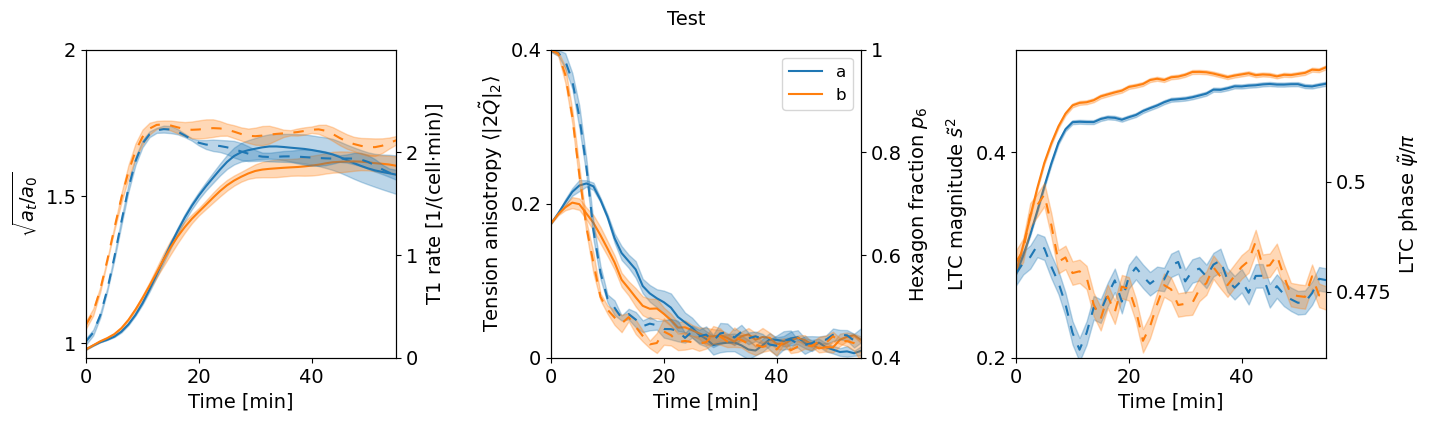

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = params[:2]
labels = [r"a", r"b"]

fig = plot_ext_T1_aniso_hex_one_orientation(keys, labels)
fig.suptitle('Test', fontsize=14);

In [ ]:
def plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True):
    if axis_labels_on_top:
        fig, (ax, bx, cx) = plt.subplots(figsize=(12, 4), ncols=3)
    else: 
        fig, (ax, bx, cx) = plt.subplots(figsize=(16, 4), ncols=3)
    alpha = 0.3
    ax2 = ax.twinx()
    for key, label, color in zip(keys, labels, colors):

        ax.plot(time, elongation_dict_mean_ori[key], color=color, label=label) 
        ax.fill_between(time, elongation_dict_mean_ori[key]-elongation_dict_std[key],
                         elongation_dict_mean_ori[key]+elongation_dict_std[key], color=color, alpha=alpha)

        ax2.plot(time, T1_rate_dict_mean_ori[key], color=color, ls=(0, (5, 5))) 
        ax2.fill_between(time, T1_rate_dict_mean_ori[key]-T1_rate_dict_std[key],
                         T1_rate_dict_mean_ori[key]+T1_rate_dict_std[key],  color=color, alpha=alpha)

    ax.set_yticks([1, 1.5, 2])
    ax.set_yticklabels([1, 1.5, 2], fontsize=14);
    ax.set_ylim([0.95, 2.2])

    ax.set_xticks([0, 20, 40, 60])
    ax.set_xticklabels([0, 20, 40, 60], fontsize=14)
    ax.set_xlim([0, 55])


    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels([0, 1, 2], fontsize=14);
    ax2.set_ylim([0, 3])

    if axis_labels_on_top:
        ax.text(0, 1.1, r'$\sqrt{a_t/a_0}$', fontsize=14, ha="center", transform=ax.transAxes)
        ax2.text(1, 1.1, r'T1 rate', fontsize=14, ha="center", transform=ax.transAxes)
    else:
        ax.set_ylabel(r'$\sqrt{a_t/a_0}$', fontsize=14)
        ax2.set_ylabel(r'T1 rate [1/(cell$\cdot$min)]', fontsize=14)


    bx2 = bx.twinx()
    for key, label, color in zip(keys, labels, colors):

        bx.plot(time, anisos_dict_mean_ori[key][:,0], color=color, label=label) 
        bx.fill_between(time, anisos_dict_mean_ori[key][:,0]-anisos_dict_std[key][:,0],
                         anisos_dict_mean_ori[key][:,0]+anisos_dict_std[key][:,0], color=color, alpha=alpha)

        bx2.plot(time, hex_dict_mean_ori[key], color=color, ls=(0, (5, 5))) 
        bx2.fill_between(time, hex_dict_mean_ori[key]-hex_dict_std[key],
                         hex_dict_mean_ori[key]+hex_dict_std[key],  color=color, alpha=alpha)

    bx.set_yticks([0, 0.2, 0.4])
    bx.set_yticklabels([0, .2, .4], fontsize=14);
    bx.set_ylim([0, 0.4])

    bx.set_xticks([0, 20, 40, 60])
    bx.set_xticklabels([0, 20, 40, 60], fontsize=14)
    bx.set_xlim([0, 55])

    bx.legend(fontsize=12, loc="upper right")
    bx2.set_yticks([0.4, 0.6, 0.8, 1])
    bx2.set_yticklabels([.4, .6, .8, 1], fontsize=14);
    bx2.set_ylim([0.4, 1])
    
    if axis_labels_on_top:
        bx.text(0, 1.1, r'$\langle|2\tilde{Q}|_2\rangle$', fontsize=14, ha="center", transform=bx.transAxes)
        bx2.text(1, 1.1, r'$p_6$', fontsize=14, ha="center", transform=bx.transAxes)
    else:
        bx.set_ylabel(r'Tension anisotropy $\langle|2\tilde{Q}|_2\rangle$', fontsize=14)
        bx2.set_ylabel(r'Hexagon fraction $p_6$', fontsize=14)
    
    cx2 = cx.twinx()
    for key, label, color in zip(keys, labels, colors):

        cx.plot(time, mean_aniso_dict_mean_ori[key], color=color, label=label) 
        cx.fill_between(time, mean_aniso_dict_mean_ori[key]-std_aniso_dict_mean_ori[key],
                         mean_aniso_dict_mean_ori[key]+std_aniso_dict_mean_ori[key], color=color, alpha=alpha)

        cx2.plot(time, mean_phase_dict_mean_ori[key], color=color, ls=(0, (5, 5))) 
        cx2.fill_between(time, mean_phase_dict_mean_ori[key]-std_phase_dict_mean_ori[key],
                         mean_phase_dict_mean_ori[key]+std_phase_dict_mean_ori[key],  color=color, alpha=alpha)

    cx.set_yticks([0.2, 0.4])
    cx.set_yticklabels([.2, .4], fontsize=14);
    cx.set_ylim([0.2, 0.5])

    cx.set_xticks([0, 20, 40, 60])
    cx.set_xticklabels([0, 20, 40, 60], fontsize=14)
    cx.set_xlim([0, 55])

    cx2.set_yticks([0.45, 0.5,])
    cx2.set_yticklabels([.45, 0.5,], fontsize=14);
    cx2.set_ylim([0.45, 0.53])
    
    if axis_labels_on_top:
        cx.text(0, 1.1, r'LTC $\tilde{s}^2$', fontsize=14, ha="center", transform=cx.transAxes)
        cx2.text(1, 1.1, r'LTC $\tilde{\psi}/\pi$', fontsize=14, ha="center", transform=cx.transAxes)
    else: 
        cx.set_ylabel(r'LTC magnitude $\tilde{s}^2$', fontsize=14,)
        cx2.set_ylabel(r'LTC phase $\tilde{\psi}/\pi$', fontsize=14)

    for xx in (ax, bx, cx):
        xx.set_xlabel('Time [min]',fontsize=14)

    plt.subplots_adjust(wspace=0.5)
    return fig

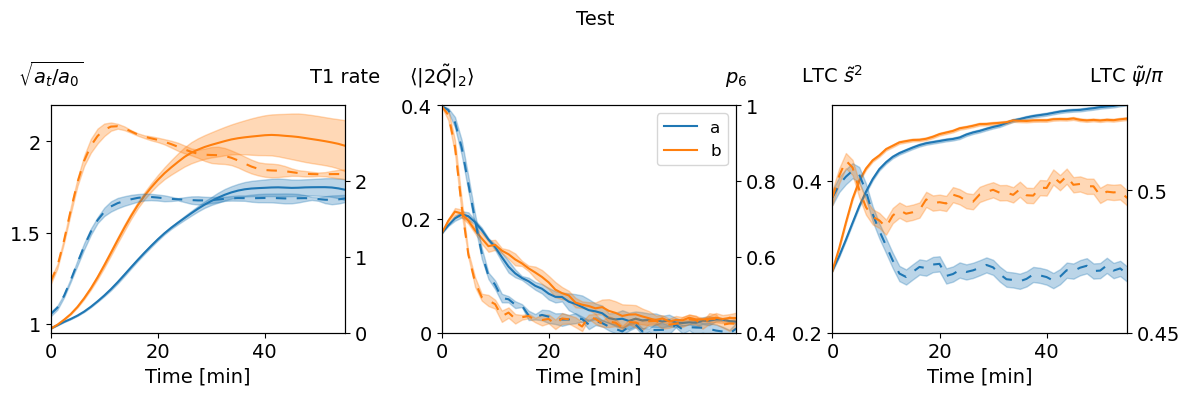

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = params_ori[:2]
labels = [r"a", r"b"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels)
fig.suptitle('Test', fontsize=14);
plt.tight_layout()

1. Dependence on:
    - tension balancing rate
    - passive relaxation rate
    - cutoff
2. Influence of initial condition:
    - gaussian noise in initial tension vertex positions 
    - orientation of hexagonal lattice
3. Area vs perimeter feedback 
4. Langevin noise in tension dynamiccs
5. Voronoi vs elastic energy minimization

In [ ]:
#  (orientation,) k_relax, k, noise_gaussian, feedback, noise_dynamic, use_voronoi, k_cutoff, (random_seed)
# default is (2, 6, 0.1, "perimeter", 0, False, 0.3)
params_ori

[(0.25, 4, 0.1, 'perimeter', 0, False, 0.3),
 (2, 6, 0.1, 'area', 0, False, 0.3),
 (2, 6, 0.1, 'perimeter', 0, False, 0.2),
 (2, 6, 0.1, 'perimeter', 0.5, False, 0.3),
 (2, 6, 0.1, 'perimeter', 0.4, False, 0.3),
 (2, 6, 0.15, 'perimeter', 0, False, 0.3),
 (2, 6, 0.1, 'perimeter', 0.2, False, 0.3),
 (0.05, 6, 0.1, 'perimeter', 0, False, 0.3),
 (2, 6, 0.1, 'perimeter', 0, True, 0.3),
 (2, 6, 0.1, 'perimeter', 0.3, False, 0.3),
 (2, 12, 0.1, 'perimeter', 0, False, 0.3),
 (0.05, 12, 0.1, 'perimeter', 0, False, 0.3),
 (0.25, 12, 0.1, 'perimeter', 0, False, 0.3),
 (2, 6, 0.05, 'perimeter', 0, False, 0.3),
 (0.25, 6, 0.1, 'perimeter', 0, False, 0.3),
 (2, 4, 0.1, 'perimeter', 0, False, 0.3),
 (2, 6, 0.1, 'perimeter', 0, False, 0.4),
 (0.05, 4, 0.1, 'perimeter', 0, False, 0.3),
 (2, 6, 0.1, 'perimeter', 0, False, 0.3)]

In [ ]:
# layout plan: assemble all into gigantic table. use top of table to label the y axes (2x per column), and the right to label what simulation it is,
# this should save a lot of space

In [ ]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2/SI/"

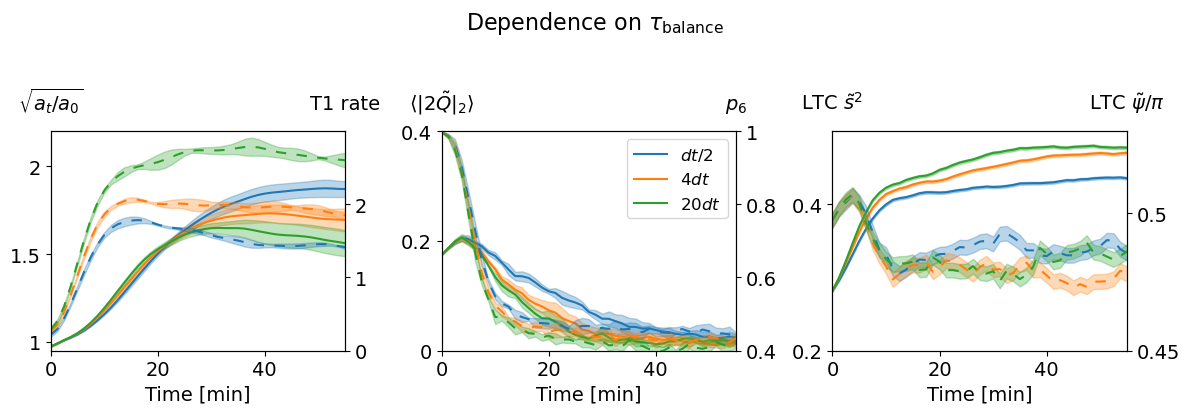

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 6, 0.1, "perimeter", 0, False, 0.3),  (0.25, 6, 0.1, "perimeter", 0, False, 0.3),  (0.05, 6, 0.1, "perimeter", 0, False, 0.3)]
labels = [r"$dt/2$", r"$4dt$", r"$20dt$"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True)
fig.suptitle(r'Dependence on $\tau_\mathrm{balance}$', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"tau_balance.pdf", transparent=True, )

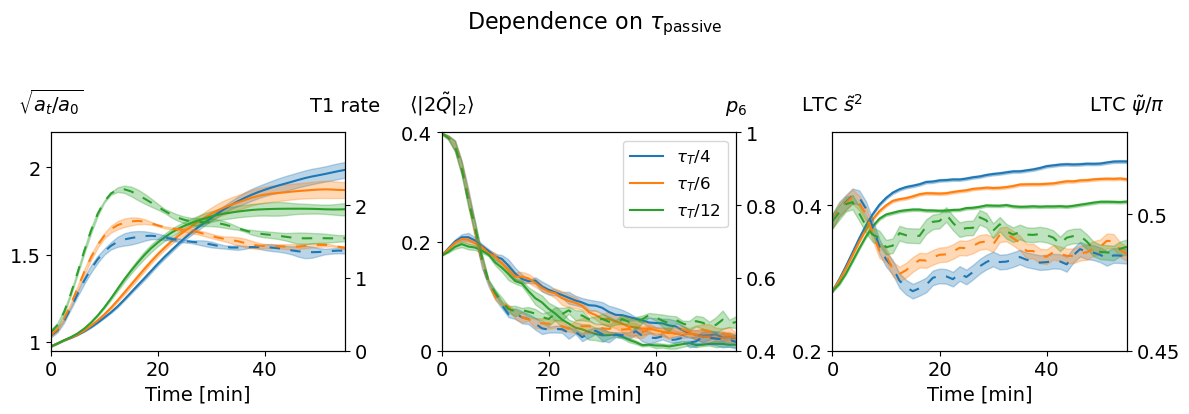

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 4, 0.1, "perimeter", 0, False, 0.3),  (2, 6, 0.1, "perimeter", 0, False, 0.3),  (2, 12, 0.1, "perimeter", 0, False, 0.3)]
labels = [r"$\tau_T/4$", r"$\tau_T/6$", r"$\tau_T/12$"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True)
fig.suptitle(r'Dependence on $\tau_\mathrm{passive}$', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"tau_passive.pdf", transparent=True)

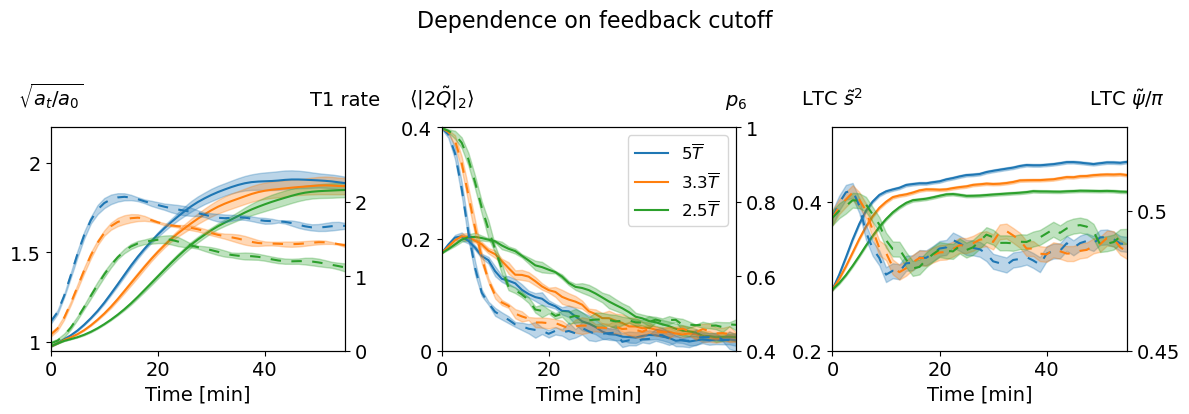

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 6, 0.1, "perimeter", 0, False, 0.2),  (2, 6, 0.1, "perimeter", 0, False, 0.3),  (2, 6, 0.1, "perimeter", 0, False, 0.4)]
labels = [r"$5\overline{T}$", r"$3.3\overline{T}$", r"$2.5\overline{T}$"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True)
fig.suptitle(r'Dependence on feedback cutoff', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"cutoff.pdf", transparent=True)

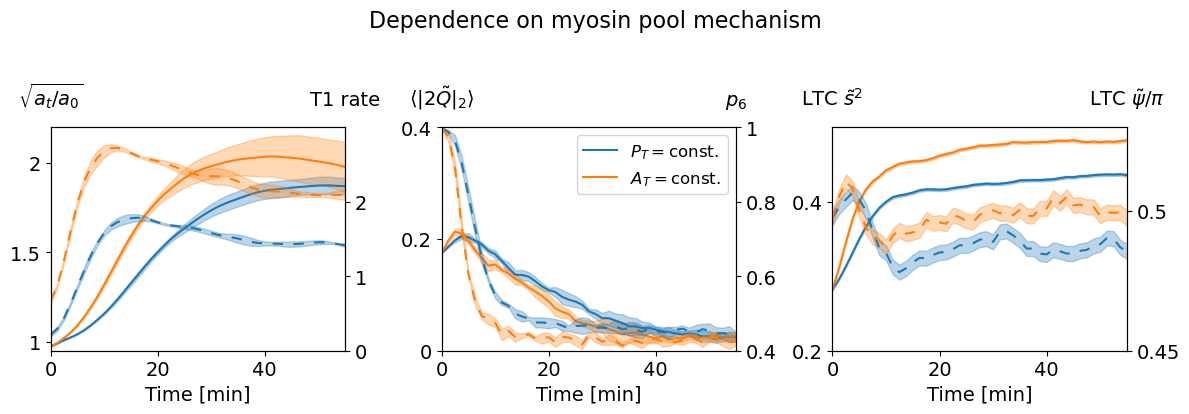

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 6, 0.1, "perimeter", 0, False, 0.3),  (2, 6, 0.1, "area", 0, False, 0.3),]
labels = [r"$P_T=\mathrm{const.}$", r"$A_T=\mathrm{const.}$"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True)
fig.suptitle(r'Dependence on myosin pool mechanism', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"pool.pdf", transparent=True)

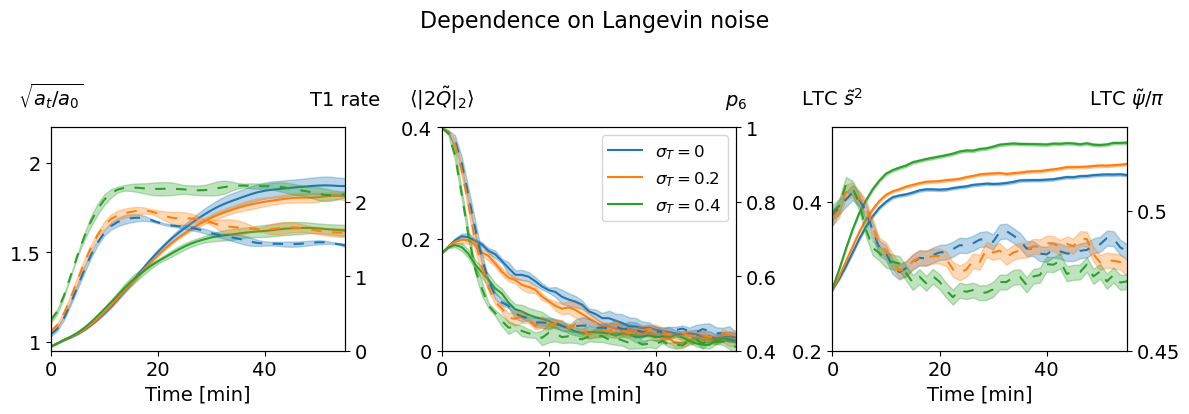

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 6, 0.1, "perimeter", 0, False, 0.3), (2, 6, 0.1, "perimeter", 0.2, False, 0.3),  (2, 6, 0.1, "perimeter", 0.4, False, 0.3)]
labels = [r"$\sigma_T=0$", r"$\sigma_T=0.2$", r"$\sigma_T=0.4$"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True)
fig.suptitle(r'Dependence on Langevin noise', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"noise_dynamic.pdf", transparent=True)

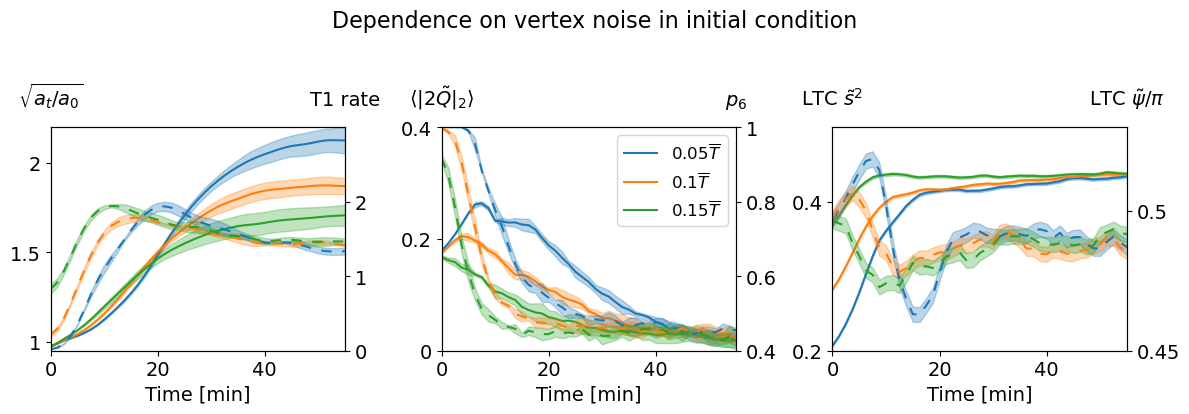

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 6, 0.05, "perimeter", 0, False, 0.3), (2, 6, 0.1, "perimeter", 0, False, 0.3), (2, 6, 0.15, "perimeter", 0, False, 0.3),]
labels = [r"$0.05\overline{T}$", r"$0.1\overline{T}$", r"$0.15\overline{T}$"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=True)
fig.suptitle(r'Dependence on vertex noise in initial condition', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"noise_initial.pdf", transparent=True)

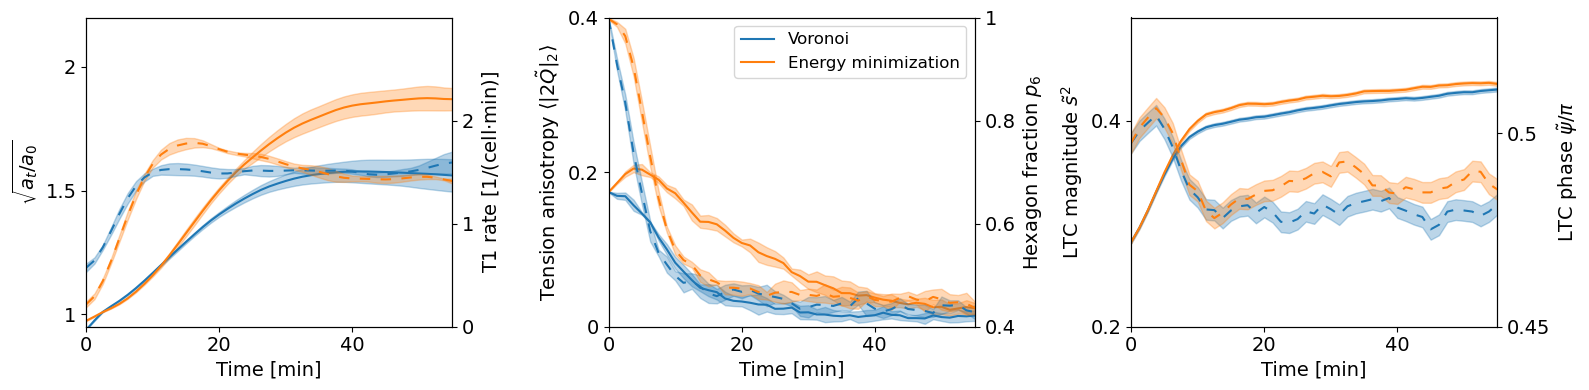

In [ ]:
colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [(2, 6, 0.1, "perimeter", 0, True, 0.3), (2, 6, 0.1, "perimeter", 0, False, 0.3)]
labels = [r"Voronoi", r"Energy minimization"]

fig = plot_ext_T1_aniso_hex_both_orientations(keys, labels, axis_labels_on_top=False)
#fig.suptitle(r'Voronoi vs elastic energy minimization', fontsize=16, y=1.025);
plt.tight_layout()
plt.savefig(plot_dir+"Voronoi.pdf", transparent=True)

# this will be its own fig

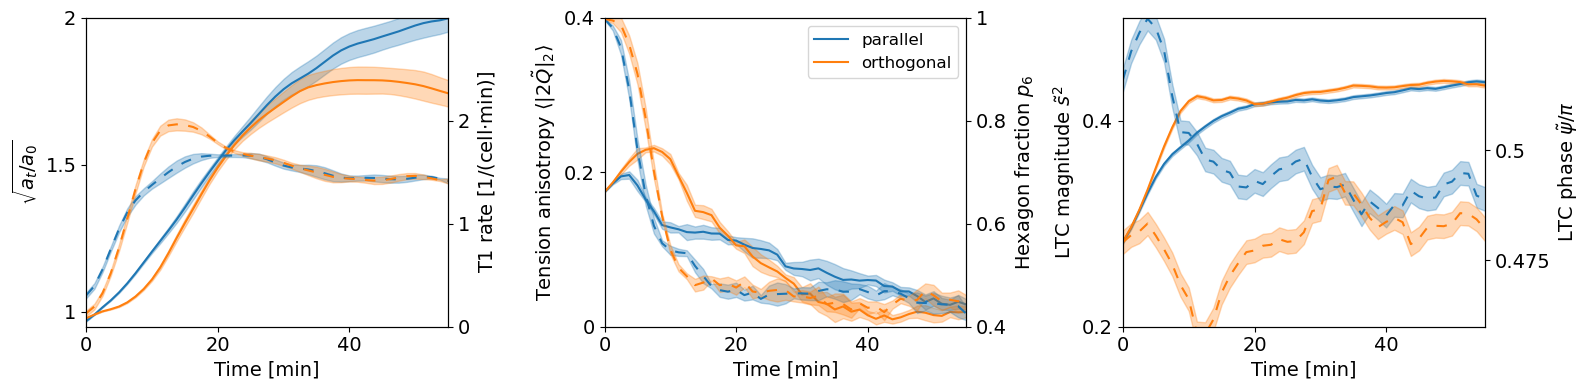

In [ ]:
## special case -  dependence on initial orientation

colors = list(mpl.colors.TABLEAU_COLORS.keys())

keys = [("parallel", 2, 6, 0.1, "perimeter", 0, False, 0.3), ("orthogonal", 2, 6, 0.1, "perimeter", 0, False, 0.3)]
labels = [r"parallel", r"orthogonal"]

fig = plot_ext_T1_aniso_hex_one_orientation(keys, labels)
#fig.suptitle(r'Dependence on initial hex. lattice orientation w.r.t. anisotropy', fontsize=16, y=1.025);

plt.tight_layout()
plt.savefig(plot_dir+"hexatic_orientation.pdf", transparent=True)

# this will be its own fig

### Plotting meshes

For Langevin, area, and Voronoi, show final meshes

In [ ]:
bdry_x, bdry_y = (31, 12)

norm = mpl.colors.Normalize(vmin=4, vmax=8)

def valence_to_colormap(val):
    return np.array(mpl.cm.PiYG(norm(val), bytes=True))/255 #PiYG, PRGn, bwr

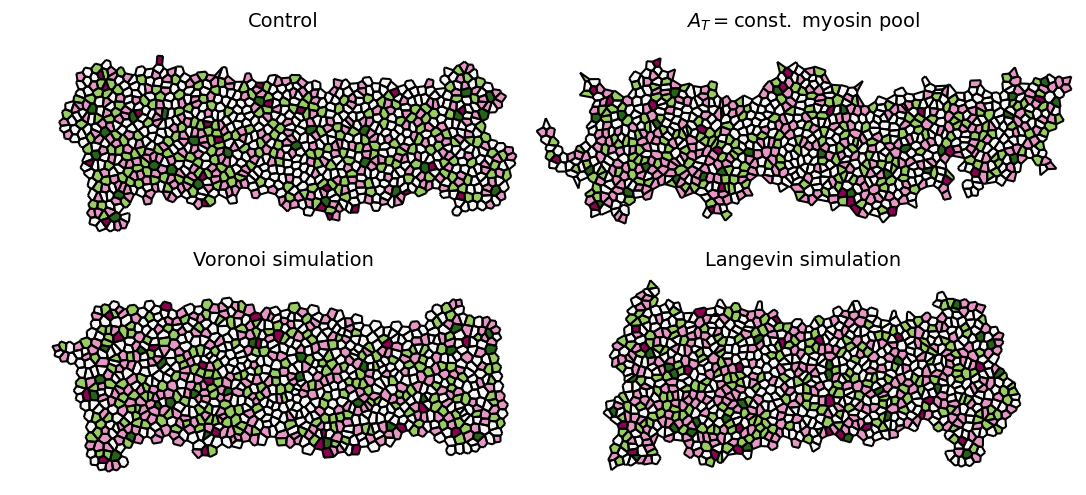

In [ ]:
# control 

t = 32

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 5), nrows=2, ncols=2)

key = ("orthogonal", 2, 6, 0.1, "perimeter", 0, False, 0.3, 1)
meshes_dict[key][t].cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()}, ax=ax1)
ax1.set_title(r"Control", fontsize=14)

key = ("orthogonal", 2, 6, 0.1, "area", 0, False, 0.3, 1)
meshes_dict[key][t].cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()}, ax=ax2)
ax2.set_title(r"$A_T=\mathrm{const.}$ myosin pool", fontsize=14)

key = ("orthogonal", 2, 6, 0.1, "perimeter", 0, True, 0.3, 1)
meshes_dict[key][t].cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()}, ax=ax3)
ax3.set_title(r"Voronoi simulation", fontsize=14)

key = ("orthogonal", 2, 6, 0.1, "perimeter", 0.4, False, 0.3, 1)
meshes_dict[key][t].cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()}, ax=ax4)
ax4.set_title(r"Langevin simulation", fontsize=14)


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([-bdry_x, bdry_x])
    ax.set_ylim([-bdry_y, bdry_y])
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=-.2)

plt.savefig(plot_dir+"SI_meshes.pdf", transparent=True)
